In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, make_scorer, confusion_matrix, mean_squared_error, mean_absolute_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

from scipy.stats import randint, uniform

In [3]:
raw_data = pd.read_csv("/Users/macbookair/Downloads/car_insurance_claim.csv")

In [4]:
pd.set_option('display.max_columns', None)
raw_data.head()

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,$0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,$0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,$0,10.0,0,Highly Urban/ Urban
3,727598473,0,05MAR64,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,$0,10.0,0,Highly Urban/ Urban
4,450221861,0,05JUN48,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,$0,6.0,0,Highly Urban/ Urban


#   DATA CLEANING

In [5]:
data_df = raw_data.copy()

We have just created a copy of our actual data and changed the column names to little descriptive names.

In [6]:
col_names = {
    'KIDSDRIV': 'num_young_drivers',
    'BIRTH': 'date_of_birth',
    'AGE': 'age',
    'HOMEKIDS': 'num_of_children',
    'YOJ': 'years_job_held_for',
    'INCOME': 'income',
    'PARENT1': 'single_parent',
    'HOME_VAL': 'value_of_home',
    'MSTATUS': 'married',
    'GENDER': 'gender',
    'EDUCATION': 'highest_education',
    'OCCUPATION': 'occupation',
    'TRAVTIME': 'commute_dist',
    'CAR_USE': 'type_of_use',
    'BLUEBOOK': 'vehicle_value',
    'TIF': 'policy_tenure',
    'CAR_TYPE': 'vehicle_type',
    'RED_CAR': 'red_vehicle',
    'OLDCLAIM': '5_year_total_claims_value',
    'CLM_FREQ': '5_year_num_of_claims',
    'REVOKED': 'licence_revoked',
    'MVR_PTS': 'license_points',
    'CLM_AMT': 'new_claim_value',
    'CAR_AGE': 'vehicle_age',
    'CLAIM_FLAG': 'is_claim',
    'URBANICITY': 'address_type'
}

# Update column names
data_df.rename(columns=col_names, inplace=True)

In [7]:
# Drop duplicates
data_df.drop_duplicates(inplace=True)

In [8]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10301 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10301 non-null  int64  
 1   num_young_drivers          10301 non-null  int64  
 2   date_of_birth              10301 non-null  object 
 3   age                        10294 non-null  float64
 4   num_of_children            10301 non-null  int64  
 5   years_job_held_for         9753 non-null   float64
 6   income                     9731 non-null   object 
 7   single_parent              10301 non-null  object 
 8   value_of_home              9726 non-null   object 
 9   married                    10301 non-null  object 
 10  gender                     10301 non-null  object 
 11  highest_education          10301 non-null  object 
 12  occupation                 9636 non-null   object 
 13  commute_dist               10301 non-null  int64  


We have observed that some columns like income includes special characters like "$" and ",". We need to change that to change the column type to Integer

In [9]:
# Define currency based columns
currency_cols = ['income', 'value_of_home', 'vehicle_value', '5_year_total_claims_value', 'new_claim_value']

# Create function to remove '$' and ','
def format_currency_cols(data, cols):
    for col in cols:
        data[col] = data[col].replace('[\\$,]', '', regex=True).astype('Int64')
    return data

data_df = format_currency_cols(data_df, currency_cols)

In [10]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10301 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         10301 non-null  int64  
 1   num_young_drivers          10301 non-null  int64  
 2   date_of_birth              10301 non-null  object 
 3   age                        10294 non-null  float64
 4   num_of_children            10301 non-null  int64  
 5   years_job_held_for         9753 non-null   float64
 6   income                     9731 non-null   Int64  
 7   single_parent              10301 non-null  object 
 8   value_of_home              9726 non-null   Int64  
 9   married                    10301 non-null  object 
 10  gender                     10301 non-null  object 
 11  highest_education          10301 non-null  object 
 12  occupation                 9636 non-null   object 
 13  commute_dist               10301 non-null  int64  


As we can see that all the data types have changed to integers as we removed the special characters.

In [11]:
# Define columns that have prefix
z_prefix_cols = ['married', 'gender', 'highest_education', 'occupation', 'vehicle_type', 'address_type']

# Create function to remove 'z_' prefix
def remove_prefix(data, cols):
    for col in cols:
        data[col] = data[col].replace('[z_]', '', regex=True)
    return data

data_df = remove_prefix(data_df, z_prefix_cols)

We need to remove this Z prefix data values from multiple columns as we can see in married, gender etc.

In [12]:
data_df.drop(['ID', 'date_of_birth'], axis=1, inplace=True)

- ID is just a unique identifier so is not needed
- data_of_birth duplicates the age feature (as age infers this information) so is not needed

In [13]:
data_df.head()

,num_young_drivers,age,num_of_children,years_job_held_for,income,single_parent,value_of_home,married,gender,highest_education,occupation,commute_dist,type_of_use,vehicle_value,policy_tenure,vehicle_type,red_vehicle,5_year_total_claims_value,5_year_num_of_claims,licence_revoked,license_points,new_claim_value,vehicle_age,is_claim,address_type
0,0,60.0,0,11.0,67349,No,0,No,M,PhD,Professional,14,Private,14230,11,Minivan,yes,4461,2,No,3,0,18.0,0,Highly Urban/ Urban
1,0,43.0,0,11.0,91449,No,257252,No,M,High School,Blue Collar,22,Commercial,14940,1,Minivan,yes,0,0,No,0,0,1.0,0,Highly Urban/ Urban
2,0,48.0,0,11.0,52881,No,0,No,M,Bachelors,Manager,26,Private,21970,1,Van,yes,0,0,No,2,0,10.0,0,Highly Urban/ Urban
3,0,35.0,1,10.0,16039,No,124191,Yes,F,High School,Clerical,5,Private,4010,4,SUV,no,38690,2,No,3,0,10.0,0,Highly Urban/ Urban
4,0,51.0,0,14.0,<NA>,No,306251,Yes,M,<High School,Blue Collar,32,Private,15440,7,Minivan,yes,0,0,No,0,0,6.0,0,Highly Urban/ Urban


In [24]:
# Define bins
bins = [0.0, 5000, 10_000, 15_000, 20_000, 25_000, 30_000, 35_000, 40_000, 45_000, 50_000, np.inf]
# Define bin labels
labels = np.arange(1, 12)

# Apply the bins using cut
data_df['claim_value_cat'] = pd.cut(data_df['new_claim_value'], bins = bins, labels= labels, include_lowest=True)

In [18]:
cols_to_drop = [
    'red_vehicle',
]

numerical_cols = ['num_young_drivers',
 'age',
 'num_of_children',
 'years_job_held_for',
 'income',
 'value_of_home',
 'commute_dist',
 'vehicle_value',
 'policy_tenure',
 '5_year_total_claims_value',
 '5_year_num_of_claims',
 'license_points',
 'vehicle_age']

# Define ordinal features
cat_cols_ord = ['highest_education']
# Define binary features
cat_cols_bin = ['single_parent', 'married', 'gender', 'type_of_use', 'licence_revoked', 'address_type']
# Define one-hot features
cat_cols_one_hot = ['occupation', 'vehicle_type']

# MODEL PIPELINE

In [19]:
# Custom transformer to drop specified columns
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(columns=self.columns_to_drop)
    
    def get_feature_names_out(self, input_features=None):
        return None

In [20]:
class SqrtTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_transform):
        self.columns_to_transform = columns_to_transform
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X[self.columns_to_transform] = np.sqrt(X[self.columns_to_transform])
        return X

    def get_feature_names_out(self, input_features=None):
        return input_features

In [21]:
from sklearn import set_config

# Set transformer output to df so we can reference columns names
set_config(transform_output='pandas')

In [22]:
# Define column dropper pipeline
cols_to_drop_pipeline = Pipeline([
    ('col_dropper', ColumnDropper(cols_to_drop))
])

skewed_features = ['income', 'value_of_home', 'commute_dist', 'vehicle_value', 'policy_tenure', 'license_points']

# Define numerical feature pipeline
num_pipeline = Pipeline([
    ('knn_imputer', KNNImputer(n_neighbors=2)),
    ('sqrt', SqrtTransformer(skewed_features)),
    ('scaler', StandardScaler()),
])

# Define rank of education levels
education_rank = [['<High School', 'High School', 'Bachelors', 'Masters', 'PhD']]

# Define ordinal categorical feature pipeline (highest_education feature)
cat_ord_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('ord_encoder', OrdinalEncoder(categories=education_rank)),
])

# Define binary categorical feature pipeline
cat_bin_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('binary_encoder', OrdinalEncoder()),
])

# Define one-hot categorical feature pipeline
cat_one_hot_pipeline = Pipeline([
    ('cat_simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')),
])

# Define preprocessing pipeline with a column transformer
preprocess_pipeline = ColumnTransformer([
    ('drop_features', cols_to_drop_pipeline, cols_to_drop),
    ('num', num_pipeline, numerical_cols),
    ('cat_ord', cat_ord_pipeline, cat_cols_ord),
    ('cat_bin', cat_bin_pipeline, cat_cols_bin),
    ('cat_one_hot', cat_one_hot_pipeline, cat_cols_one_hot),
])

In [25]:
# Filter to only rows with a non-zero claim value
claim_data = data_df[data_df['new_claim_value'] > 0]

# Create clean copy of training data
X_reg = claim_data.copy()
y_reg = claim_data['new_claim_value']

# Drop the target feature
X_reg.drop(columns=['new_claim_value','is_claim', 'claim_value_cat'], inplace=True)

# Create train/test split
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

In [26]:
# Use the same pipeline as the classifier model to preprocess X train
X_reg_train_prepared = preprocess_pipeline.fit_transform(X_reg_train)

# MODEL SELECTION

We'll start by looking at the performance of some of the most popular regression models.

In [35]:
regs = [
    ('Linear Regression', LinearRegression()),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=25, solver='sag', tol=3)),
    ('SGD Regressor', SGDRegressor(random_state=42)),
    ('Decision Tree Regression ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('KNN Model ', KNeighborsRegressor()),
    ('Support Vector Machines (SVM)', SVR(gamma=2, C=1))
]

Like with the classification models, we'll use a KFold object to use the same folds for the cross-validation of each model.

For the scoring of the model, we'll use the RMSE as it's more sensitive to outliers.

In [36]:
# Create KFold object with 10 folds
reg_kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Dictionary to store results
reg_results = {}

# Evaluate each classifier using cross-validation
for reg_name, reg in regs:
    print(reg_name)
    cv_rmses = -cross_val_score(reg, X_reg_train_prepared, y_reg_train, cv=reg_kf, scoring='neg_root_mean_squared_error')
    reg_results[reg_name] = cv_rmses

reg_cv_scores_df = pd.DataFrame(reg_results)

Linear Regression
Logistic Regression
SGD Regressor
Decision Tree Regression 
Random Forest
KNN Model 
Support Vector Machines (SVM)


And again, let's create a boxplot of the results of the cross-validation for each model.

Text(0.5, 1.0, 'Cross-Validation Scores for Different Regressors')

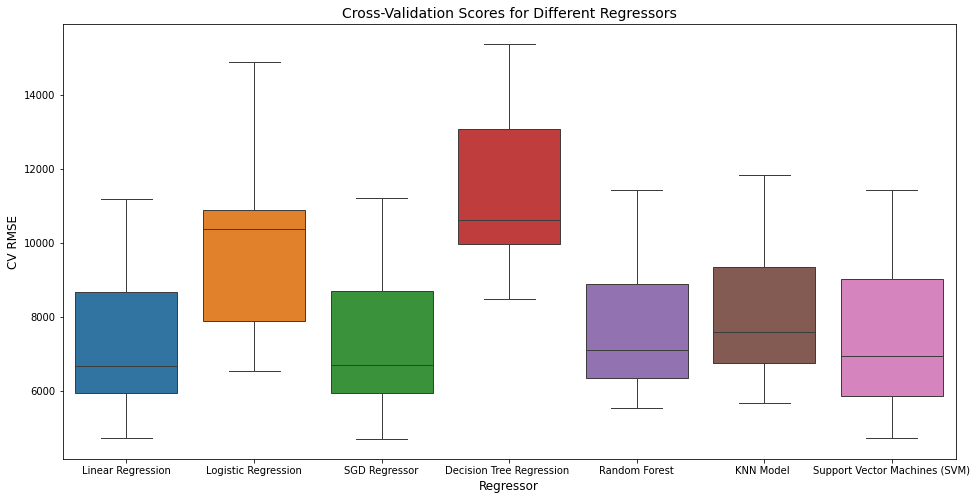

In [37]:
# Plot scores
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(reg_cv_scores_df)

# Add axis labels
ax.set_xlabel('Regressor', fontsize=12)
ax.set_ylabel('CV RMSE', fontsize=12)
ax.set_title('Cross-Validation Scores for Different Regressors', fontsize=14)

As we're using the RMSE as the scoring method, lower is better. We can see the linear regression and SGD Regressor models performed the best. Their scores were very similar, as the models themselves are. As we have more flexibility to tune the SGD Regressor, we'll proceed with that.

# HYPERPARAMETER OPTIMISATION

As we did with the classification model, we'll first use random search to cover a large parameter space.

In [38]:
# Define the parameter grid for SGDRegressor
reg_param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate': ['constant', 'invscaling'],
    'eta0': uniform(0.001, 0.1),
    'max_iter': randint(100, 1000),
    'tol': uniform(1e-6, 1e-3)
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_random_search = RandomizedSearchCV(
    estimator=sgd_regressor,
    param_distributions=reg_param_grid,
    n_iter=500,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Fit the model using RandomizedSearchCV
reg_random_search.fit(X_reg_train_prepared, y_reg_train)

score = np.sqrt(-reg_random_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_random_search.best_params_)
print("Best cross-validation score: ", score)

Fitting 10 folds for each of 500 candidates, totalling 5000 fits

Best parameters found:  {'alpha': 0.008548753109694546, 'eta0': 0.003327193573582587, 'learning_rate': 'invscaling', 'max_iter': 214, 'penalty': 'l2', 'tol': 0.0004970374542934063}
Best cross-validation score:  7606.542104820654

We can now use grid search with the reduce parameter space.

In [42]:
# Define the parameter grid for SGDRegressor
reg_param_grid_gs = {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.004, 0.008, 0.012],
    'learning_rate': ['invscaling'],
    'eta0': [0.001, 0.003, 0.005],
    'max_iter': [180, 200, 220],
    'tol': [1e-5, 1e-4, 1e-6]
}

# Initialise the regressor
sgd_regressor = SGDRegressor(random_state=42)

# Create random search
reg_grid_search = GridSearchCV(
    estimator=sgd_regressor,
    param_grid=reg_param_grid_gs,
    scoring='neg_mean_squared_error',
    cv=reg_kf,
    verbose=1,
    n_jobs=-1
)

In [ ]:
# Fit the model
reg_grid_search.fit(X_reg_train_prepared, y_reg_train)

reg_score = np.sqrt(-reg_grid_search.best_score_)

# Print the best parameters and the best score
print("Best parameters found: ", reg_grid_search.best_params_)
print("Best cross-validation score: ", reg_score)

Fitting 10 folds for each of 243 candidates, totalling 2430 fits

Best parameters found:  {'alpha': 0.012, 'eta0': 0.003, 'learning_rate': 'invscaling', 'max_iter': 180, 'penalty': 'l2', 'tol': 1e-05}

Best cross-validation score:  7605.2923588743715

# MODEL EVALUATION

We can now test our regression model with the test sets to see our final score.

In [47]:
reg_cv_scores_df["SGD Regressor"].mean()

7379.111618747787

In [46]:
X_reg_test_prepared = preprocess_pipeline.fit_transform(X_reg_test)

y_reg_pred = reg_grid_search.best_estimator_.predict(X_reg_test_prepared)

mse = mean_squared_error(y_reg_test, y_reg_pred)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_reg_test, y_reg_pred)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

RMSE: 8378.846093356431
MAE: 3556.2627508324217


We can see the RMSE score was slightly higher than what we saw in the train sets, but still fairly inline. As with the classification model, there is still lots of room for potential improvement, like additional feature engineering, investigating feature importance or combining multiple models to create an ensemble.